In [1]:
import gc

import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import confusion_matrix

from src.utils import calculate_profit, train_val_test_split, signed_log10_1p, ProfitMetric

## Construct the `profit` and `profitable` variables

In [2]:
funnel = pd.read_csv('train_data/funnel.csv')
funnel['profit'] = calculate_profit(funnel)
funnel['log_profit'] = funnel['profit'].apply(signed_log10_1p)
funnel['profitable'] = (funnel['profit'] > 0).astype(int)

## Prepare quarters for grouping

In [3]:
months_to_quarters = {
    '2018-09-30': 'Q1',
    '2018-10-31': 'Q1',
    '2018-11-30': 'Q1',
    '2018-12-31': 'Q2',
    '2019-01-31': 'Q2',
    '2019-02-28': 'Q2',
    '2019-03-31': 'Q3',
    '2019-04-30': 'Q3',
    '2019-05-31': 'Q3',
    '2019-06-30': 'Q4',
    '2019-07-31': 'Q4',
    '2019-08-31': 'Q4',
    '2019-09-30': 'Q4'
}

## Construct balances


In [4]:
balances = pd.read_csv('train_data/balance.csv')
balances['quarter'] = balances['month_end_dt'].replace(months_to_quarters)

# Sum up across all accounts by month
account_sums = balances.groupby(['client_id', 'month_end_dt'])[['avg_bal_sum_rur', 'max_bal_sum_rur', 'min_bal_sum_rur']].sum()

# Get average range (max - min) for all clients
account_sums['range'] = account_sums['max_bal_sum_rur'] - account_sums['min_bal_sum_rur']
avg_range = account_sums['range'].mean(level='client_id', skipna=True)

# Get the average amount in the last month
balance_last = account_sums.iloc[account_sums.index.get_level_values('month_end_dt') == '2019-08-31']
balance_last = balance_last['avg_bal_sum_rur']
balance_last.index = balance_last.index.droplevel('month_end_dt')
all_avg = account_sums['avg_bal_sum_rur'].mean(level=0)

# Get mean avg by quarters
bal_mean_q = balances.groupby(['client_id', 'quarter'])['avg_bal_sum_rur'].mean()

m3 = bal_mean_q[bal_mean_q.index.get_level_values('quarter') == 'Q4'].droplevel(1)
m6 = bal_mean_q[bal_mean_q.index.get_level_values('quarter').isin(['Q4', 'Q3'])].mean(level=0)
m12 = bal_mean_q.mean(level=0)

balance_ft = pd.DataFrame({
    'balance_range': avg_range,
    'balance_last_avg': balance_last,
    'balance_m3': m3,
    'balance_all_avg': all_avg,
    'balance_rel_range': avg_range / all_avg,
    'balance_diff_m3': balance_last - m3,
    'balance_diff_m6': balance_last - m6,
    'balance_diff_m3_m6': m3 - m6,
    'balance_diff_m3_m12': m3 - m12,
    'balance_diff_m3_rel': (balance_last - m3) / m3,
    'balance_diff_m6_rel': (balance_last - m6) / m3,
    'balance_diff_m3_m6_rel': (m3 - m6) / m3,
    'balance_diff_m3_m12_rel': (m3 - m12) / m3,
})
del all_avg, balances, account_sums, avg_range, balance_last, bal_mean_q, m3, m6, m12

In [5]:
balance_ft.describe()

,balance_range,balance_last_avg,balance_m3,balance_all_avg,balance_rel_range,balance_diff_m3,balance_diff_m6,balance_diff_m3_m6,balance_diff_m3_m12,balance_diff_m3_rel,balance_diff_m6_rel,balance_diff_m3_m6_rel,balance_diff_m3_m12_rel
count,18625.000000,18625.000000,18625.000000,18625.000000,1.192800e+04,18625.000000,18625.000000,18625.000000,18625.000000,1.095500e+04,1.135300e+04,1.135300e+04,1.188000e+04
mean,52.086197,-90.898470,-8.894519,-69.249358,inf,-82.003951,-81.827563,0.176388,-2.096344,inf,NaN,NaN,NaN
std,173.264351,934.211685,260.229700,856.256206,NaN,783.180384,786.292911,26.585861,103.712030,NaN,NaN,NaN,NaN
min,0.000000,-31173.000000,-5631.000000,-28987.666667,-3.730000e+02,-29393.811321,-29237.405660,-959.833333,-8986.270833,-6.010000e+02,-inf,-inf,-inf
25%,0.000000,0.000000,0.000000,0.000000,-1.054552e-01,-1.285714,-2.000000,0.000000,-0.100000,4.117647e-01,3.125000e-01,-1.174433e-01,-2.734671e-01
50%,10.833333,0.000000,0.000000,0.000000,4.998547e-01,0.000000,0.000000,0.000000,0.000000,2.940401e+00,2.883538e+00,0.000000e+00,5.943302e-02
75%,50.833333,7.000000,3.500000,8.750000,2.280093e+00,1.800000,2.333333,1.307292,1.916667,7.495424e+00,7.489877e+00,2.167832e-01,4.065376e-01
max,7792.083333,38052.000000,19026.000000,34881.000000,inf,25452.500000,25257.909722,689.333333,2894.250000,inf,inf,inf,inf


## Construct AUM

Same as with balances, but now for assets under managament

In [6]:
aum = pd.read_csv('train_data/aum.csv')
aum['quarter'] = aum['month_end_dt'].replace(months_to_quarters)

# Sum up across all accounts for each month
aum_sums = aum.groupby(['client_id', 'month_end_dt', 'quarter'])['balance_rur_amt'].sum()

# Get mean and STD for last few months for client
aum_std = aum_sums.std(level='client_id', skipna=True)
aum_mean = aum_sums.mean(level='client_id', skipna=True)

# Get the average amount in the last month
aum_last = aum_sums.iloc[aum_sums.index.get_level_values('month_end_dt') == '2019-08-31']
aum_last.index = aum_last.index.droplevel(['month_end_dt', 'quarter'])

# Get quarter averages
aum_sums_q = aum_sums.mean(level=['client_id', 'quarter'])

m3 = aum_sums_q[aum_sums_q.index.get_level_values('quarter') == 'Q4'].droplevel(1)
m6 = aum_sums_q[aum_sums_q.index.get_level_values('quarter').isin(['Q4', 'Q3'])].mean(level=0)
m12 = aum_sums_q.mean(level=0)

# Create features
aum_ft = pd.DataFrame({
    'aum_std': aum_std,
    'aum_last': aum_last,
    'aum_m3': m3,
    'aum_all_avg': aum_mean,
    'aum_volatility': aum_std/aum_mean,
    'aum_diff_m3': aum_last - m3,
    'aum_diff_m6': aum_last - m6,
    'aum_diff_m3_m6': m3 - m6,
    'aum_diff_m3_m12': m3 - m12,
    'aum_diff_m3_rel': (aum_last - m3) / m3,
    'aum_diff_m6_rel': (aum_last - m6) / m3,
    'aum_diff_m3_m6_rel': (m3 - m6) / m3,
    'aum_diff_m3_m12_rel': (m3 - m12) / m3,  
})
del aum, aum_sums, aum_std, aum_mean, aum_last, aum_sums_q, m3, m6, m12

In [7]:
aum_ft.describe()

,aum_std,aum_last,aum_m3,aum_all_avg,aum_volatility,aum_diff_m3,aum_diff_m6,aum_diff_m3_m6,aum_diff_m3_m12,aum_diff_m3_rel,aum_diff_m6_rel,aum_diff_m3_m6_rel,aum_diff_m3_m12_rel
count,1.233600e+04,1.164000e+04,1.199400e+04,1.262500e+04,12215.000000,1.164000e+04,1.164000e+04,1.199400e+04,1.199400e+04,11515.000000,1.154100e+04,1.186500e+04,1.187900e+04
mean,6.753699e+04,1.679808e+05,1.654494e+05,1.515324e+05,0.932881,-1.170125e+03,5.624825e+03,6.444587e+03,1.868308e+04,-0.047832,-inf,NaN,NaN
std,3.048220e+05,9.818141e+05,9.318728e+05,7.298385e+05,0.672041,1.474859e+05,2.312114e+05,1.233481e+05,3.131885e+05,0.675079,NaN,NaN,NaN
min,0.000000e+00,-2.078000e+03,-2.059667e+03,-1.213000e+03,-1.739190,-3.653605e+06,-3.434124e+06,-3.433422e+06,-3.829687e+06,-4.000000,-inf,-inf,-inf
25%,3.975839e+03,4.895000e+02,2.136000e+03,3.973556e+03,0.466303,-7.791167e+03,-9.190375e+03,-1.816458e+03,-3.060417e+03,-0.531622,-6.979382e-01,-2.272995e-01,-5.057203e-01
50%,1.461534e+04,1.163150e+04,1.591967e+04,1.634433e+04,0.839445,0.000000e+00,-8.333333e+01,0.000000e+00,0.000000e+00,-0.000212,-4.331307e-02,1.589982e-04,1.910440e-03
75%,4.718967e+04,6.324600e+04,7.073025e+04,6.585210e+04,1.292106,3.513083e+03,5.960583e+03,6.682708e+03,1.206865e+04,0.184224,2.339255e-01,2.227885e-01,3.368823e-01
max,1.942198e+07,6.464412e+07,6.405032e+07,4.828950e+07,3.162278,7.464487e+06,1.451986e+07,7.055372e+06,2.025258e+07,2.000000,2.500000e+00,inf,inf


## Construct client dataset

In [8]:
client = pd.read_csv('train_data/client.csv')

# Take out citizenship and job_type, they are useless
client_ft = client.set_index('client_id')[['gender', 'age', 'region', 'city', 'education']]

# Filter out cities and region to only those above 200, make them categorical (not numerical)
region_counts = client_ft['region'].value_counts(dropna=False)
top_regions = region_counts[region_counts > 200].index

city_counts = client_ft['city'].value_counts(dropna=False)
top_cities = city_counts[city_counts > 200].index

client_ft.loc[~ client_ft['city'].isin(top_cities), 'city'] = None
client_ft.loc[~ client_ft['region'].isin(top_regions), 'region'] = None

client_ft['city'] = client_ft['city'].astype('str')
client_ft['region'] = client_ft['region'].astype('str')

client_ft[['gender', 'education']] = client_ft[['gender', 'education']].fillna('nan')

In [9]:
client_ft.describe(include='all')

,gender,age,region,city,education
count,21498,21495.000000,21498,21498,21498
unique,3,NaN,29,17,8
top,F,NaN,nan,nan,nan
freq,11116,NaN,4461,13862,12218
mean,NaN,43.097139,NaN,NaN,NaN
std,NaN,10.798968,NaN,NaN,NaN
min,NaN,21.000000,NaN,NaN,NaN
25%,NaN,34.000000,NaN,NaN,NaN
50%,NaN,42.000000,NaN,NaN,NaN
75%,NaN,52.000000,NaN,NaN,NaN


## Construct transaction features

In [10]:
column_names = ['client_id', 'tran_amt_rur', 'mcc_cd', 'tran_time', 'txn_country']
transaction = pd.read_csv('data/trxn.csv', usecols=column_names)[column_names]
transaction['month'] = pd.to_datetime(transaction.tran_time).dt.date + MonthEnd(1)
transaction['month'] = transaction['month'].apply(lambda x: x.strftime('%Y-%m-%d'))
transaction['quarter'] = transaction['month'].replace(months_to_quarters)
transaction.drop(columns=['tran_time'], inplace=True)

# Share spent abroad
trn_abr = transaction.query('txn_country != "RUS"').groupby('client_id')['tran_amt_rur'].sum()
trn_total = transaction.groupby('client_id')['tran_amt_rur'].sum()
trn_share_abr = (trn_abr / trn_total).fillna(0)

# Amount spent each month and some stats about it
transaction_sums = transaction.groupby(['client_id', 'quarter', 'month'])['tran_amt_rur'].sum()
trn_std = transaction_sums.std(level='client_id', skipna=True)
trn_mean = transaction_sums.mean(level='client_id', skipna=True)

del transaction

# Bring in payments to construct residual income
payments = pd.read_csv('data/payments.csv')
payments['month'] = pd.to_datetime(payments['day_dt']).apply(lambda x: x + MonthEnd(1))
payments['month'] = payments['month'].apply(lambda x: x.strftime('%Y-%m-%d'))
payment_sums = payments.groupby(['client_id', 'month'])['sum_rur'].sum()
del payments

residual_income = payment_sums - transaction_sums.droplevel('quarter')
del payment_sums

# Raw fts
transactions_raw_ft = transaction_sums.droplevel('quarter').unstack().rename(columns= lambda x: f'transactions_{x}')
res_inc_raw_ft = residual_income.unstack().rename(columns= lambda x: f'res_inc_{x}')

# Get quarterly transactions
trn_sums_q = transaction_sums.mean(level=['client_id', 'quarter'])

m3 = trn_sums_q[trn_sums_q.index.get_level_values('quarter') == 'Q4'].droplevel(1)
m6 = trn_sums_q[trn_sums_q.index.get_level_values('quarter').isin(['Q4', 'Q3'])].mean(level=0)
m12 = trn_sums_q.mean(level=0)

# Create features
transaction_ft = pd.DataFrame({
    'trn_share_abr': trn_share_abr,    
    'trn_std': trn_std,
    'trn_m3': m3,
    'trn_all_avg': trn_mean,
    'trn_volatility': trn_std/trn_mean,
    'trn_diff_m3': transactions_raw_ft['transactions_2019-08-31'] - m3,
    'trn_diff_m6': transactions_raw_ft['transactions_2019-08-31'] - m6,
    'trn_diff_m3_m6': m3 - m6,
    'trn_diff_m3_m12': m3 - m12,
    'trn_diff_m3_rel': (transactions_raw_ft['transactions_2019-08-31'] - m3) / m3,
    'trn_diff_m6_rel': (transactions_raw_ft['transactions_2019-08-31'] - m6) / m3,
    'trn_diff_m3_m6_rel': (m3 - m6) / m3,
    'trn_diff_m3_m12_rel': (m3 - m12) / m3,  
})

del transaction_sums, trn_sums_q

In [12]:
# column_names = ['client_id', 'tran_amt_rur', 'mcc_cd', 'tran_time', 'txn_country']
# transaction = pd.read_csv('data/trxn.csv', usecols=column_names)[column_names]
# transaction_ft = transaction
# del transaction
# gc.collect()
# transaction_ft['mcc_cd'] = transaction_ft['mcc_cd'].astype('str')

# temp_trs = transaction_ft.groupby(['client_id', 'mcc_cd']).sum().reset_index()
# transaction_ft = temp_trs.loc[temp_trs.groupby('client_id').tran_amt_rur.idxmax()]
# transaction_ft = transaction_ft.set_index('client_id')
# transaction_ft['tran_amt_rur'] = transaction_ft['tran_amt_rur'].fillna('nan')
# del temp_trs
# gc.collect()

## Construct payment features

In [13]:
payments = pd.read_csv('data/payments.csv')

payments['month'] = pd.to_datetime(payments['day_dt']).apply(lambda x: x + MonthEnd(1))
payments['month'] = payments['month'].apply(lambda x: x.strftime('%Y-%m-%d'))
payments['quarter'] = payments['month'].replace(months_to_quarters)

# Get pensioneers
pensioneers = payments.query('pmnts_name == "Pension receipts"').client_id.unique()
pensioneers = pd.Series(1.0, index=pensioneers)

payments_sums = payments.groupby(['client_id', 'month', 'quarter'])['sum_rur'].sum()

# Get mean and STD for last few months for client
payments_std = payments_sums.std(level='client_id', skipna=True)
payments_mean = payments_sums.mean(level='client_id', skipna=True)

# Get payments last month
payments_last = payments_sums.iloc[payments_sums.index.get_level_values('month') == '2019-08-31']
payments_last.index = payments_last.index.droplevel(['month', 'quarter'])

# Get quarter averages
payments_sums_q = payments_sums.mean(level=['client_id', 'quarter'])

m3 = payments_sums_q[payments_sums_q.index.get_level_values('quarter') == 'Q4'].droplevel(1)
m6 = payments_sums_q[payments_sums_q.index.get_level_values('quarter').isin(['Q4', 'Q3'])].mean(level=0)
m12 = payments_sums_q.mean(level=0)

# Create features
payments_ft = pd.DataFrame({
    'is_pensioneer': pensioneers,
    'payments_std': payments_std,
    'payments_last': payments_last,
    'payments_all_avg': payments_mean,
}).fillna({'is_pensioneer': 0})

payments_raw_ft = payments_sums.droplevel('quarter').unstack().rename(columns= lambda x: f'payments_{x}')

del payments, payments_sums, payments_std, payments_mean, payments_last, payments_sums_q, m3, m6, m12, pensioneers

In [14]:
payments_ft.describe()

,is_pensioneer,payments_std,payments_last,payments_all_avg
count,8954.000000,8.752000e+03,7.670000e+03,8.954000e+03
mean,0.134242,4.033943e+04,5.530271e+04,5.884695e+04
std,0.340931,1.636440e+05,9.686230e+04,9.290501e+04
min,0.000000,0.000000e+00,0.000000e+00,2.400000e+01
25%,0.000000,1.027182e+04,1.460900e+04,2.313831e+04
50%,0.000000,2.301505e+04,3.118250e+04,4.227073e+04
75%,0.000000,4.547850e+04,6.265050e+04,7.113442e+04
max,1.000000,9.266212e+06,4.173208e+06,3.563451e+06


## Construct mystery features

In [15]:
mystery_feats = pd.read_csv('train_data/funnel.csv', usecols=['client_id'] + [f'feature_{i}' for i in range(1, 11)])
mystery_feats = mystery_feats.set_index('client_id')
mystery_feats['feature_1'] = mystery_feats['feature_1'].astype(str)

## Construct final dataset

In [16]:
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable', 'log_profit']
CAT_FEATURES = ['gender', 'region', 'city', 'education', 'feature_1']
LABEL = 'log_profit'

labels_all = funnel.set_index('client_id')[LABEL_COLS]
full_data = pd.concat([
    labels_all,
    balance_ft,
    aum_ft,
    client_ft,
    transaction_ft,
    transactions_raw_ft,
    res_inc_raw_ft,
    payments_ft,
    payments_raw_ft,    
    mystery_feats
], axis=1)
full_data = full_data.fillna({'mcc_cd': 'nan'})

## Split into train, val, test

In [17]:
train, val, test = train_val_test_split(full_data, [0.8, 0.1, 0.1])

train_pool = Pool(
    data = train.drop(LABEL_COLS, axis=1),
    label = train[LABEL],
    cat_features=CAT_FEATURES
)

val_pool = Pool(
    data = val.drop(LABEL_COLS, axis=1), 
    label = val[LABEL],
    cat_features=CAT_FEATURES
)
test_pool = Pool(data = test.drop(LABEL_COLS, axis=1), cat_features=CAT_FEATURES)

print(val.profit.mean())
print(test.profit.mean())
print(train.profit.mean())

3043.2036976744193
2805.0767441860467
2501.6929265030817


## Construct model

In [66]:
model = CatBoostRegressor(
    iterations=1500,
    depth=10,
    learning_rate=0.05,
    loss_function='RMSE',
    use_best_model=True,
)

## Run training

In [67]:
model.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=300)

0:	learn: 2.8891515	test: 2.9414564	best: 2.9414564 (0)	total: 118ms	remaining: 2m 57s
100:	learn: 2.1059267	test: 2.3276888	best: 2.3276888 (100)	total: 9.52s	remaining: 2m 11s
200:	learn: 1.9320401	test: 2.3083587	best: 2.3076258 (192)	total: 19s	remaining: 2m 2s
300:	learn: 1.7947180	test: 2.3067962	best: 2.3047569 (264)	total: 29s	remaining: 1m 55s
400:	learn: 1.6780933	test: 2.3064127	best: 2.3047569 (264)	total: 40.2s	remaining: 1m 50s
500:	learn: 1.5695915	test: 2.3028301	best: 2.3028301 (500)	total: 51.6s	remaining: 1m 42s
600:	learn: 1.4752179	test: 2.3063835	best: 2.3028301 (500)	total: 1m 2s	remaining: 1m 33s
700:	learn: 1.3913287	test: 2.3052404	best: 2.3028301 (500)	total: 1m 15s	remaining: 1m 26s
800:	learn: 1.3189789	test: 2.3064003	best: 2.3028301 (500)	total: 1m 28s	remaining: 1m 17s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.30283011
bestIteration = 500

Shrink model to first 501 iterations.


## Evaluate profitability of solution on val

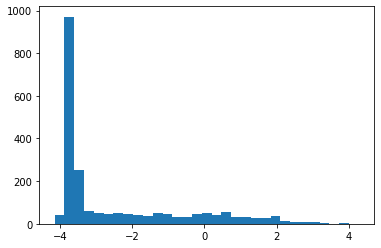

In [68]:
import matplotlib.pyplot as plt
plt.hist(model.predict(val_pool), bins=31);

In [69]:
for threshold in np.arange(-3, -1, 0.1):
    pred_val = model.predict(val_pool) > threshold
    bs_prof_val = val['profit'].mean()

    model_prof_val = calculate_profit(val)[pred_val.astype(bool)].sum()
    model_prof_val = model_prof_val / len(pred_val)

    print(f'VAL {threshold} | Baseline profit: {bs_prof_val:.2f}, model profit: {model_prof_val:.2f}')

VAL -3.0 | Baseline profit: 3043.20, model profit: 5887.59
VAL -2.9 | Baseline profit: 3043.20, model profit: 5900.63
VAL -2.8 | Baseline profit: 3043.20, model profit: 5884.03
VAL -2.6999999999999997 | Baseline profit: 3043.20, model profit: 5932.14
VAL -2.5999999999999996 | Baseline profit: 3043.20, model profit: 5927.44
VAL -2.4999999999999996 | Baseline profit: 3043.20, model profit: 5955.62
VAL -2.3999999999999995 | Baseline profit: 3043.20, model profit: 5931.13
VAL -2.2999999999999994 | Baseline profit: 3043.20, model profit: 5961.54
VAL -2.1999999999999993 | Baseline profit: 3043.20, model profit: 5982.61
VAL -2.099999999999999 | Baseline profit: 3043.20, model profit: 6021.51
VAL -1.9999999999999991 | Baseline profit: 3043.20, model profit: 6028.39
VAL -1.899999999999999 | Baseline profit: 3043.20, model profit: 5957.57
VAL -1.799999999999999 | Baseline profit: 3043.20, model profit: 5916.79
VAL -1.6999999999999988 | Baseline profit: 3043.20, model profit: 5926.27
VAL -1.59999

In [72]:
threshold = - 2.0

## Evaluate profitability of solution on test

In [73]:
pred_test = model.predict(test_pool) > threshold
bs_prof_test = test['profit'].mean()

model_prof_test = calculate_profit(test)[pred_test.astype(bool)].sum()
model_prof_test = model_prof_test / len(pred_test)

print(f'TEST | Baseline profit: {bs_prof_test:.2f}, model profit: {model_prof_test:.2f}')

TEST | Baseline profit: 2805.08, model profit: 5579.93


## Notes

1. Using just balance  or features, I get below baseline
2. Using balance + client features, I get 3074 on test,  3345.24 on val
3. Using balance + aum + client fts, I get 2944.95 on test, 3607.06 on val
4. Same as prev step - but using regressor, I get crazy 5289 on test, 5792 on val
5. Same step as prev, but using signed log on profit + thresholding I get 5906.70 on val, and 5516.17 on test
6. Same as prev + transaction features, I get 5887.00 on val, and 5442.85 ont test
7. above + payment fts, I get 5959.00 on val, 5458.27 on test
8. above + mystery fts, I get 5961.78 on val, and 5597.67 on test
9. above + transforming balances, val: 6012.78, test: 5628.89
10. above + transforming aum, val: 6021.99, test: 5692.18
11. above + transforming payments, val: 5998.36, test: 5637.98
12. above + adding payments current, val: 6001.72, test: 5632.70
13. above + raw payments fts, val: 6005.82, test: 5673.20
14. above + replace last by m3 in denominator, val: 5975.54, test: 5687.57
14. above + remove most non raw payments, val: 6024.09, test: 5662.89

## Grid search for best params

In [43]:
# full_data_train= full_data.drop(LABEL_COLS, axis=1)
# full_data_pool = Pool(
#     data = full_data_train, 
#     label = full_data['log_profit'],              
#     cat_features=CAT_FEATURES
# )

# model = CatBoostRegressor(
#     iterations=800,
#     depth=10,
#     loss_function='RMSE',
#     verbose=100,
# )

# gs_res = model.grid_search(
#     X=full_data_pool,
#     search_by_train_test_split=True,
#     train_size=0.8,
#     partition_random_seed=42,
#     param_grid={'depth': [8,10], 'l2_leaf_reg': [1, 3, 6], 'bagging_temperature': [0, 1, 2]},
#     verbose=True,
# )

0:	learn: 3.7203829	test: 3.7351161	best: 3.7351161 (0)	total: 52.7ms	remaining: 42.1s
100:	learn: 2.2224008	test: 2.3342680	best: 2.3342680 (100)	total: 3.5s	remaining: 24.2s
200:	learn: 2.0952214	test: 2.3056926	best: 2.3056022 (199)	total: 6.9s	remaining: 20.6s
300:	learn: 2.0023438	test: 2.2974083	best: 2.2973916 (299)	total: 10.3s	remaining: 17.1s
400:	learn: 1.9126309	test: 2.2942901	best: 2.2939830 (398)	total: 13.7s	remaining: 13.7s
500:	learn: 1.8308330	test: 2.2946462	best: 2.2937266 (418)	total: 17.2s	remaining: 10.3s
600:	learn: 1.7514030	test: 2.2949913	best: 2.2935787 (533)	total: 20.9s	remaining: 6.92s
700:	learn: 1.6776017	test: 2.2940100	best: 2.2934143 (613)	total: 24.6s	remaining: 3.47s
799:	learn: 1.6148429	test: 2.2917679	best: 2.2914382 (786)	total: 28.3s	remaining: 0us

bestTest = 2.291438236
bestIteration = 786

0:	loss: 2.2914382	best: 2.2914382 (0)	total: 28.3s	remaining: 8m 1s
0:	learn: 3.7207847	test: 3.7354321	best: 3.7354321 (0)	total: 38.6ms	remaining: 30

## Feature importance

In [25]:
model.get_feature_importance(val_pool, 
    type='FeatureImportance', prettified=True
)

,Feature Id,Importances
0,education,23.230235
1,feature_1,4.390605
2,feature_9,3.240426
3,feature_4,3.207407
4,feature_6,2.827445
...,...,...
92,res_inc_2019-04-30,0.265015
93,payments_all_avg,0.223602
94,payments_2018-12-31,0.201345
95,feature_5,0.148844


## Save model on FULL data and save it

In [26]:
model.save_model('models/tadej_model.cbm', 'cbm')

## Test load, data and produce predictions

In [27]:
# Save data first, as it would be in the build step
full_data.drop(LABEL_COLS, axis=1).to_pickle('final_version.pickle')

In [28]:
model = CatBoostRegressor().load_model('models/tadej_model.cbm', 'cbm')
data = pd.read_pickle('final_version.pickle')
data_pool = Pool(data = data, cat_features=CAT_FEATURES)

target = (model.predict(data_pool) > threshold).astype(int)
submission = pd.DataFrame({'client_id': data.index, 'target': target})
submission.to_csv('submission.csv', index=False)

In [29]:
pd.read_csv('submission.csv')

,client_id,target
0,-9221941791080978530,0
1,-9220369594510368140,0
2,-9220236243053692422,1
3,-9220233431709087652,1
4,-9219699286371310531,0
...,...,...
21493,9219024469308275500,0
21494,9219416956046769492,0
21495,9219968212912398941,0
21496,9220335314469087849,0
